In [1]:
# To store the data
import pandas as pd

# To do linear algebra
import numpy as np

# To create plots
import matplotlib.pyplot as plt

# To create interactive plots
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

# To shift lists
from collections import deque

# To compute similarities between vectors
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# To use recommender systems
import surprise as sp
from surprise.model_selection import cross_validate

# To create deep learning models
from keras.layers import Input, Embedding, Reshape, Dot, Concatenate, Dense, Dropout
from keras.models import Model

# To create sparse matrices
from scipy.sparse import coo_matrix

# To light fm
from lightfm import LightFM
from lightfm.evaluation import precision_at_k

# To stack sparse matrices
from scipy.sparse import vstack

c:\Users\abene\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning:

LightFM was compiled without OpenMP support. Only a single thread will be used.



***
## <a id=2>2. Load Movie-Data</a>

In [2]:
# Load data for all movies
movie_titles = pd.read_csv('movie_titles_processed.csv', 
                           encoding = 'ISO-8859-1', 
                           header = None, 
                           names = ['Id', 'Year', 'Name']).set_index('Id')

print('Shape Movie-Titles:\t{}'.format(movie_titles.shape))
movie_titles.sample(5)

Shape Movie-Titles:	(17771, 2)


,Year,Name
Id,,
17491,2002,Like Mike
156,1992,Husbands and Wives
13469,2000,The Gleaners and I
14864,2002,Garage Days
11988,2001,The Void


There are roughly **18.000 movies** in the ratings dataset and the metadata for the movies contains only the **release date and the movie title.**

In [3]:
# Load a movie metadata dataset
movie_metadata = pd.read_csv('../IMDB_data/movie_titles_IMDB_merge.csv', low_memory=False)
# Select necessary columns
movie_metadata = movie_metadata[['Name', 'description', 'NumRating', 'AggregateAverageRating', 'Directors', 'creators', 'Genre', 'Keywords', 'duration', 'actors', 'contentRating']]
# Set movie name as index
movie_metadata = movie_metadata.set_index('Name')
# Remove movies with less than 10 ratings
movie_metadata = movie_metadata[movie_metadata['NumRating'] > 10]
# Drop 'NumRating' column
movie_metadata = movie_metadata.drop('NumRating', axis=1)

print('Shape Movie-Metadata:\t{}'.format(movie_metadata.shape))
movie_metadata.sample(5)

Shape Movie-Metadata:	(13464, 9)


,description,AggregateAverageRating,Directors,creators,Genre,Keywords,duration,actors,contentRating
Name,,,,,,,,,
Captain Pantoja and the Special Services,"The Peruvian army captain Pantaleon Pantoja, a...",7.1,Francisco J. Lombardi,creators,"Comedy, Drama","infatuation,sex scene,big breasts,rape,sex comedy",137.0,NaN,R
Guilty as Sin,A female lawyer takes an accused wife-murderer...,5.6,Sidney Lumet,creators,"Crime, Drama, Thriller","female stockinged feet,foot closeup,camera sho...",107.0,NaN,R
The Cherokee Kid,A child's parents are killed by a vicious land...,6.0,Paris Barclay,creators,"Comedy, Western","land grab,gunfighter,revenge,bank robbery,bandit",91.0,NaN,PG-13
The Child I Never Was,The practice of female genital mutilation is e...,7.5,Kim Longinotto,creators,Documentary,"female genital mutilation,female circumcision",90.0,NaN,Not Rated
Malice Aforethought,Dr. Edmund Bickleigh is married to a particula...,6.8,David Blair,creators,"Mystery, Crime, Drama","doctor,extramarital affair,buxom,rich wife,fem...",180.0,NaN,TV-14


About **21.000 entries** are in the movie metadata dataset. 

***
## <a id=3>3. Load User-Data And Preprocess Data-Structure</a>

The user-data structure has to be preprocessed to extract all ratings and form a matrix, since the file-structure is a messy mixture of json and csv.

In [5]:
from collections import deque

dfs = []

# Load each Netflix data file and process it
for i in range(1, 5):
    file = f'combined_data_{i}.txt'
    df_raw = pd.read_csv(file, header=None, names=['User', 'Rating', 'Date'], usecols=[0, 1, 2])

    # Find empty rows to slice dataframe for each movie
    tmp_movies = df_raw[df_raw['Rating'].isna()]['User'].reset_index()
    movie_indices = [[index, int(movie[:-1])] for index, movie in tmp_movies.values]

    # Shift the movie_indices by one to get start and endpoints of all movies
    shifted_movie_indices = deque(movie_indices)
    shifted_movie_indices.rotate(-1)

    # Gather all dataframes
    user_data = []

    # Iterate over all movies
    for [df_id_1, movie_id], [df_id_2, next_movie_id] in zip(movie_indices, shifted_movie_indices):

        # Check if it is the last movie in the file
        if df_id_1 < df_id_2:
            tmp_df = df_raw.loc[df_id_1+1:df_id_2-1].copy()
        else:
            tmp_df = df_raw.loc[df_id_1+1:].copy()

        # Create movie_id column
        tmp_df['Movie'] = movie_id

        # Append dataframe to list
        user_data.append(tmp_df)

    # Combine all dataframes for this file
    dfs.append(pd.concat(user_data))

# Combine all dataframes from all files
df = pd.concat(dfs)

# Clean up variables
del df_raw, tmp_movies, tmp_df, shifted_movie_indices, movie_indices, df_id_1, movie_id, df_id_2, next_movie_id, dfs, user_data

print('Shape User-Ratings:\t{}'.format(df.shape))
df.sample(5)


Shape User-Ratings:	(100480507, 4)


,User,Rating,Date,Movie
20404633,1330487,3.0,2005-08-22,16698
8056045,2181504,4.0,2005-07-06,5845
22030921,2144655,5.0,2004-12-08,13232
4436691,797754,5.0,2005-11-02,872
4383954,507902,3.0,2005-07-26,14192


There are about **24.000.000 different ratings**.<br>
I loaded only a single file of four to reduce memory footprint and accelerate computation. Keep in mind that this approach could introduce biases in the data.

***
## <a id=4>4. When Were The Movies Released?</a>

In [6]:
import plotly.graph_objs as go
import plotly.io as pio

# Get data
data = movie_titles['Year'].value_counts().sort_index()

# Create trace
trace = go.Scatter(x=data.index,
                   y=data.values,
                   marker=dict(color='#db0000'))

# Create layout
layout = dict(title='{} Movies Grouped By Year Of Release'.format(movie_titles.shape[0]),
              xaxis=dict(title='Release Year'),
              yaxis=dict(title='Movies'))

# Create figure
fig = go.Figure(data=[trace], layout=layout)
pio.show(fig)


Many movies on Netflix have been released in this millennial. Whether Netflix prefers young movies or there are no old movies left can not be deduced from this plot.<br>
The decline for the rightmost point is probably caused by an **incomplete last year.**

***
## <a id=5>5. How Are The Ratings Distributed?</a>

In [7]:
from plotly.offline import iplot
# Get data
data = df['Rating'].value_counts().sort_index(ascending=False)

# Create trace
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               marker = dict(color = '#db0000'))
# Create layout
layout = dict(title = 'Distribution Of {} Netflix-Ratings'.format(df.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

Netflix movies rarely have a rating lower than three. **Most ratings have between three and four stars.**<br>
The distribution is probably biased, since only people liking the movies proceed to be customers and others presumably will leave the platform.

***
## <a id=6>6. When Have The Movies Been Rated?</a>

In [8]:
# Get data
data = df['Date'].value_counts()
data.index = pd.to_datetime(data.index)
data.sort_index(inplace=True)

# Create trace
trace = go.Scatter(x = data.index,
                   y = data.values,
                   marker = dict(color = '#db0000'))
# Create layout
layout = dict(title = '{} Movie-Ratings Grouped By Day'.format(df.shape[0]),
              xaxis = dict(title = 'Date'),
              yaxis = dict(title = 'Ratings'))

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

With beginning of november 2005  a strange decline in ratings can be observed. Furthermore two unnormal peaks are in january and april 2005.

***
## <a id=7>7. How Are The Number Of Ratings Distributed For The Movies And The Users?</a>



In [9]:
##### Ratings Per Movie #####
# Get data
data = df.groupby('Movie')['Rating'].count().clip(upper=9999)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 10000,
                                  size = 100),
                     marker = dict(color = '#db0000'))
# Create layout
layout = go.Layout(title = 'Distribution Of Ratings Per Movie (Clipped at 9999)',
                   xaxis = dict(title = 'Ratings Per Movie'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)



##### Ratings Per User #####
# Get data
data = df.groupby('User')['Rating'].count().clip(upper=199)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 200,
                                  size = 2),
                     marker = dict(color = '#db0000'))
# Create layout
layout = go.Layout(title = 'Distribution Of Ratings Per User (Clipped at 199)',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [27]:
# Convert 'Year' column to numeric format
movie_titles['Year'] = pd.to_numeric(movie_titles['Year'], errors='coerce')

year_count = movie_titles['Year'].value_counts().sort_index()
year_bar = go.Bar(x=year_count.index, y=year_count.values, marker=dict(color='rgba(0, 204, 204, 0.5)', line=dict(color='rgb(0,0,0)',width=1.5)))
layout = go.Layout(title='Distribution of Movie Release Years', xaxis=dict(title='Year'), yaxis=dict(title='Count'))
fig = go.Figure(data=[year_bar], layout=layout)
fig.show()

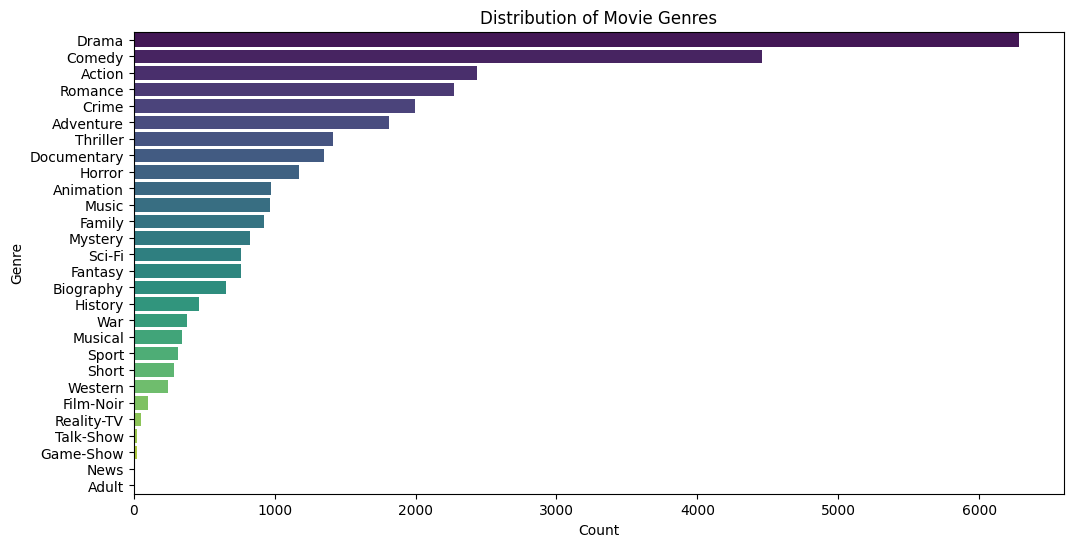

In [33]:
# Split and count genres
genre_count = movie_metadata['Genre'].str.split(', ').explode().value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_count.values, y=genre_count.index, palette='viridis')
plt.title('Distribution of Movie Genres')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()


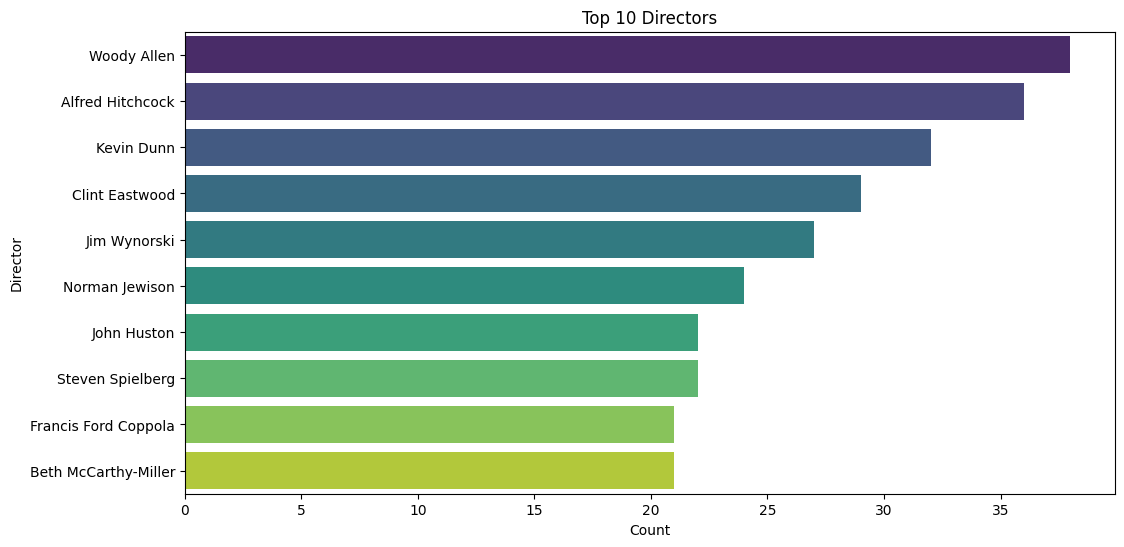

In [30]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Directors
top_directors = movie_metadata['Directors'].str.split(', ').explode().value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_directors.values, y=top_directors.index, palette='viridis')
plt.title('Top 10 Directors')
plt.xlabel('Count')
plt.ylabel('Director')
plt.show()


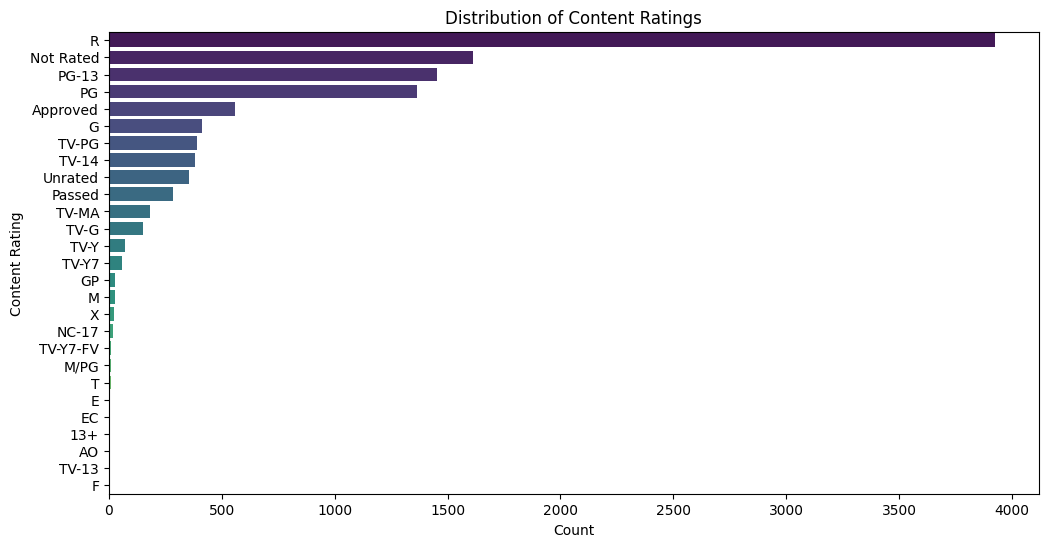

In [35]:
content_rating_count = movie_metadata['contentRating'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=content_rating_count.values, y=content_rating_count.index, palette='viridis')
plt.title('Distribution of Content Ratings')
plt.xlabel('Count')
plt.ylabel('Content Rating')
plt.show()


In [38]:
duration_hist = go.Histogram(x=movie_metadata['duration'], nbinsx=int(movie_metadata['duration'].max()//10), marker=dict(color='rgba(0, 204, 204, 0.5)', line=dict(color='rgb(0,0,0)',width=1.5)))
layout = go.Layout(title='Distribution of Movie Durations', xaxis=dict(title='Duration (minutes)'), yaxis=dict(title='Count'))
fig = go.Figure(data=[duration_hist], layout=layout)
fig.show()

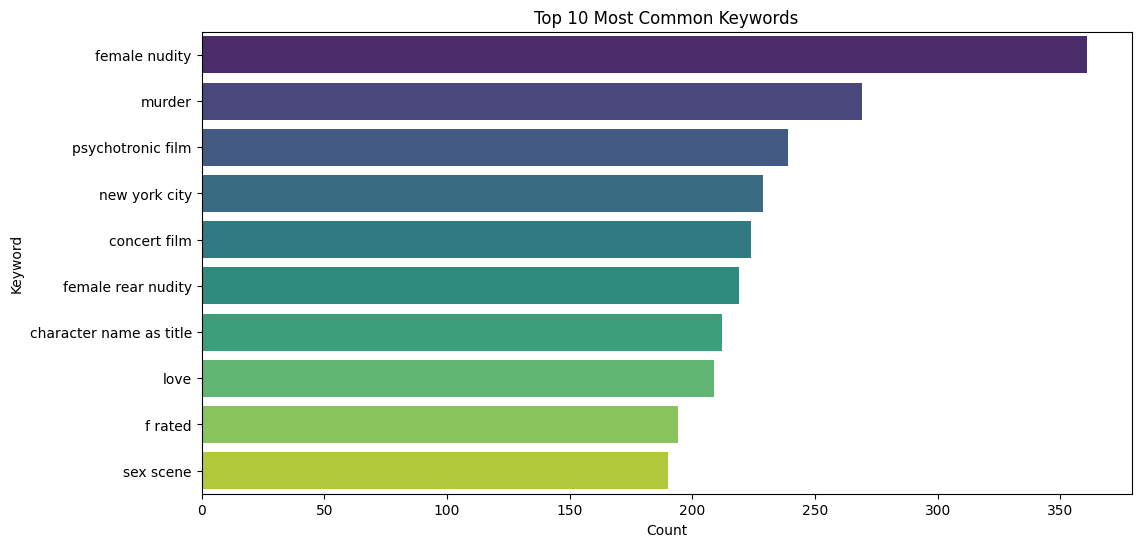

In [16]:
# Split and count keywords
keyword_count = movie_metadata['Keywords'].str.split(',').explode().value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=keyword_count.values, y=keyword_count.index, palette='viridis')
plt.title('Top 10 Most Common Keywords')
plt.xlabel('Count')
plt.ylabel('Keyword')
plt.show()


In [44]:
df['Date'] = pd.to_datetime(df['Date'])
df['day_of_week'] = df['Date'].dt.dayofweek
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year


The ratings per movie as well as the ratings per user both have nearly a perfect **exponential decay**. Only very few 
movies/users have many ratings. 

***
## <a id=8>8. Filter Sparse Movies And Users</a>

To reduce the dimensionality of the dataset filter the rarely rated movies and rarely rating users out.

In [19]:
# Filter sparse movies
min_movie_ratings = 10000
filter_movies = (df['Movie'].value_counts()>min_movie_ratings)
filter_movies = filter_movies[filter_movies].index.tolist()

# Filter sparse users
min_user_ratings = 200
filter_users = (df['User'].value_counts()>min_user_ratings)
filter_users = filter_users[filter_users].index.tolist()

# Actual filtering
df_filterd = df[(df['Movie'].isin(filter_movies)) & (df['User'].isin(filter_users))]
del filter_movies, filter_users, min_movie_ratings, min_user_ratings
print('Shape User-Ratings unfiltered:\t{}'.format(df.shape))
print('Shape User-Ratings filtered:\t{}'.format(df_filterd.shape))

Shape User-Ratings unfiltered:	(100480507, 4)
Shape User-Ratings filtered:	(60546559, 4)
